# Lab 1 - K-Nearest Neighbours

This lab is about the implementation and analysis of the KNN algorithm for classification problems

In [ ]:
#Matteo Pastorino Ghezzi
#Riccardo Caprile
#Andrea Valli

In [87]:
# Packages used
%matplotlib notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.interpolate import griddata
import os
import pickle
np.random.seed(100)
from sklearn.metrics.pairwise import euclidean_distances  # importing this function to speed up the KNN

### Assignment 0: Data generation for binary classification

We start generating a training set for binary classification problems. Consider the following function, that generates random 2D points on the plane and assigns them a binary label according to their position w.r.t. a linear separator.

Implement a function `linearBinaryClass` which given a sample size `n`, lower and upper bounds `low_D, high_D` for the domain of the samples and the linear function parameters `m, q`, generates a binary classification dataset i.e. it returns `X` and `Y`.

The signature of the function is the following:

`X, Y = linearBinaryClass(n, low_D, high_D, m, q)`

where
- **n** is the number of samples to be generated
- **low_D** and **high_D** are, respectively, the lower and upper bounds for the domain of the samples (there was a formula here but I can't see it)
- **m, q** are the linear function parameters
- **X**, **Y**: 2-dimensional samples (X) associated with 1-dimensional binary labels (Y)

**Hint**: you can use the functions defined in Lab0.

In [88]:
def linearBinaryClass(n, D, low_D, high_D, m, q):   # modified arguments' function: added dimension D
    X = np.zeros((n, D))
    Y = np.zeros(n)

    # sampling of the X
    for i in range(D):
      X[:,i] = np.random.uniform(low_D, high_D, size=n)
    
    # assigning the labels depending on the position of the sample with respect to the linear separator
    Y[X[:,1] - (X[:,0] * m + q) > 0] = 1 
    Y[Y==0] = -1
    
    return X,Y

### Computing the distance between input points

In order to build the KNN estimator we need to resort to a distance function.

Consider a function that computes the euclidean distance between two points...

In [89]:
def euclidDistance(P1,P2):
    return np.linalg.norm(P1-P2,2)

'def euclidDistance(P1,P2):\n    return np.linalg.norm(P1-P2,2)'

... and then a function that computes all the distance between two set of points stored in two matrices.

In [90]:
def allDistances(X1, X2):
    D = np.zeros((X1.shape[0], X2.shape[0]))
    for idx1 in range(len(X1)):
        for idx2 in range(len(X2)):
            D[idx1,idx2] = euclidDistance(X1[idx1,:],X2[idx2,:])
    return D

'def allDistances(X1, X2):\n    D = np.zeros((X1.shape[0], X2.shape[0]))\n    for idx1 in range(len(X1)):\n        for idx2 in range(len(X2)):\n            D[idx1,idx2] = euclidDistance(X1[idx1,:],X2[idx2,:])\n    return D'

The usage is the following:

**D = allDistances(X1,X2)**

where
- **X1** is a matrix of size $n_1 \times D$, where each row is a D-dimensional point
- **X2** is a matrix of size $n_2 \times D$, where each row is a D-dimensional point
- **D** is a matrix of size $n_1 \times n_2$, where each element `D[i,j]` is the distance between points (`X1[i, :]`, `X2[j, :]`)

<font color=red>**Optional [NOT EVALUATED]**</font>:
The `allDistances` function is very inefficient. Can you come up with a faster way to compute the distances between all pairs of points in two matrices?

In [91]:
# Provide here a faster version of the function allDistances
def allDistances(X1, X2):
    D = euclidean_distances(X1,X2)
    return D

### Assignment 1: adding noise to the samples

To make the task harder, we may want to perturb the labels with some noise.

In our case, we have binary labels and a common way of adding noise is to flip the value of a small percentage of the labels. For example, if a label was $+1$ it will become $-1$.

Implement the `flipLabels` function which takes two arguments:
 - `Y`, the numpy array of original labels
 - `P`, an integer between 1 and 100 specifying the percentage of labels which will be flipped
and returns an array of the same shape as `Y`, which contains the noisy labels.

**Hint**: You can use the functions defined in Lab0.

In [92]:
def flipLabels(Y, P):
    if P < 1 or P > 100:
        print("P should be a percentage value between 0 and 100.")
        return -1

    if any(np.abs(Y) != 1):
        print("The values of Ytr should be +1 or -1.")
        return -1

    Y_noisy = np.copy(np.squeeze(Y))
    if Y_noisy.ndim > 1:
        print("Please supply a label array with only one dimension")
        return -1

    n = Y_noisy.size
    n_flips = int(np.floor(n * P / 100))
    idx_to_flip = np.random.choice(n, size=n_flips, replace=False)
    Y_noisy[idx_to_flip] = -Y_noisy[idx_to_flip]
    
    return Y_noisy

### Assignment 2: The KNN classifier

We are now ready to use the KNN algorithm to estimate the classification function. 

Implement the `kNNClassify` function which train a KNN classifier on given training set and returns predictions on a given test set. 

The signature of the function is the following:

`Ypred = kNNClassify(Xtr, Ytr, k, Xte)`

where
- **Xtr** is a matrix of size [ntr, D], where each row is a D-dimensional point (INPUT IN THE **TRAINING SET**)
- **Ytr** is an array of size [ntr], where each element is a binary label (OUTPUT IN THE **TRAINING SET**)
- **k** is the number of neighbours to be considered
- **Xte** is a matrix of size [nte, D], where each row is a D-dimensional point (INPUT IN THE **TEST SET**)
- **Ypred** is an array of size [nte], where each element is a binary label (ESTIMATED OUTPUT FOR THE **TEST SET**)

where [ntr] and [nte] are respectively the number of points in the training set and the number of points in the test set

In [93]:
def kNNClassify(Xtr, Ytr, k, Xte):

    n_train = Xtr.shape[0] # number of the training inputs
    n_test = Xte.shape[0] # number of the test inputs

    if any(np.abs(Ytr) != 1):
        raise Exception("The values of Ytr should be +1 or -1.")

    if k > n_train:
        print("k is greater than the number of points, setting k=n_train")
        k = n_train

    Ypred = np.zeros(n_test)

    
    # Compute all the distances from test input and training input
    dist = allDistances(Xtr, Xte) 
    
    # For each test point, the predicted class will be 
    # the sign of the average label of the k nearest points
    for idx in range(n_test):
        nearest_neighbor_ids = np.argsort(dist[idx,:])[:k]
        Ypred[idx] = np.sign(np.mean(Ytr[nearest_neighbor_ids]))
    return Ypred


### Visualizing the separating function

The visualization of the separating function on the training set, i.e. the function estimated by classification algorithm for discriminating between classes, is of benefit for appreciating the behavior of the binary classifier. To visualize the separating function use the following:

**_separatingFkNN(Xtr, Ytr, k)_**

where
- **Xtr** is a matrix of size [ntr, D], where each row is a D-dimensional point (INPUT IN THE **TRAINING SET**)
- **Ytr** is an array of size [ntr], where each element is a binary label (OUTPUT IN THE **TRAINING SET**)
- **k** is the number of neighbours to be considered

In [94]:
def separatingFkNN(Xtr, Ytr, k):
    Ypred = kNNClassify(Xtr=Xtr, Ytr=Ytr, k=k, Xte=Xtr)

    x = Xtr[:, 0]
    y = Xtr[:, 1]
    xi = np.linspace(x.min(), x.max(), 200)
    yi = np.linspace(y.min(), y.max(), 200)
    zi = griddata((x, y), Ypred, (xi[None, :], yi[:, None]), method='linear')

    plt.subplots()
    CS = plt.contour(xi, yi, zi, 15, linewidths=2, colors='k', levels=[0])
    # plot data points.
    plt.scatter(x, y, c=Ytr, marker='o', s=50, zorder=10, alpha=0.8)
    plt.xlim(x.min(), x.max())
    plt.ylim(x.min(), x.max())
    msg = 'Separating function, k='+str(k);
    plt.title(msg)

### Evaluating the goodness of a classifier

To evaluate how good is the classification function estimated by the KNN, we compare the predicted binary labels and expected (true) ones, with the following function:

`err = calcError(Ypred, Ytrue)`

where
- **Ypred** is an array of size $n$, where each element is a binary label predicted by the classifier
- **Ytrue** is an array of size $n$, where each element is the true binary label
- **err** is the fraction of wrongly classified elements wrt the total number


In [95]:
def calcError(Ypred, Ytrue):
    return (np.count_nonzero(Ypred != Ytrue)) / len(Ytrue)

### Assignment 3: Noise-free case

In this assignment, we start to play with the NN classifier. In specific:

- 1.Generate a training set WITHOUT NOISE
- 2.Visualize the separating curve for the **NN** classifier 
- 3.Generate a test set with the same amount of noise as the training set.
- 4.Compute the error on the TRAINING and then on the TEST SET



With K=1 the error on the test set is  0.505
With K=1 the error on the training set is  0.0


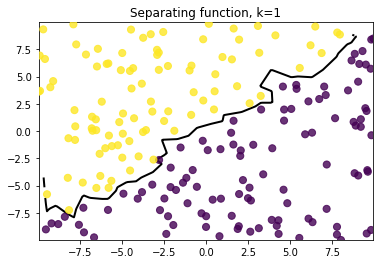

In [96]:
### Generate training and test sets, build and evaluate the KNN classifier

n = 200
D = 2

m = 0.9
q = 0.0

low_D = -10
high_D = 10

k = 1

# Generate a training set WITHOUT NOISE
Xtr, Ytr = linearBinaryClass(n, D, low_D, high_D, m, q)

# Visualize the separating curve for the NN classifier
separatingFkNN(Xtr, Ytr, k)

# Generate a test set WITHOUT NOISE
Xte, Yte = linearBinaryClass(n, D, low_D, high_D, m, q)

'''# plotting for the test as well for curiosity's sake
separatingFkNN(Xte, Yte, k)'''

# Evaluate the NN classifier on the TEST SET
Ypred = kNNClassify(Xtr, Ytr, k, Xte)

# Compute the error on the TEST SET
err = calcError(Ypred, Yte)

print("With K=%d the error on the test set is " % (k), err)

# How the classifier perform on the TRAINING SET instead? ---> just change the last argument on kNNClassify!
Ypredtr = kNNClassify(Xtr, Ytr, k, Xtr) # by doing this, I'm valuating the fitting capability
errtr = calcError(Ypredtr, Ytr)
print("With K=%d the error on the training set is " % (k), errtr)


### Assignment 4: adding noise

Keeping the parameters of the function and the number of points as in the previous assignment:

- 1.Generate a training set WITH NOISE (for instance with 10% of flipped labels)
- 2.Visualize the separating curve for the **NN** classifier 
- 3.Generate a test set with the same amount of noise as the training set.
- 4.Evaluate the NN classifier on the TRAINING and on the TEST SET
- 5.Compute the obtained error on the TRAINING and on the TEST SET

- Repeat the steps from 1 to 5 with the **KNN** algorithm, setting for instance K=5

OBSERVE WHAT CHANGES...

With K=1 the error on the test set is  0.55
With K=1 the error on the training set is  0.0
With K=5 the error on the test set is  0.52
With K=5 the error on the training set is  0.115


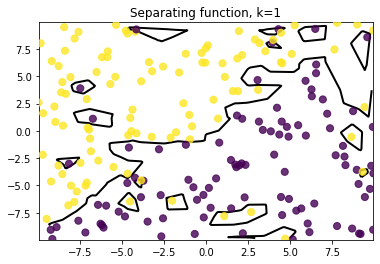

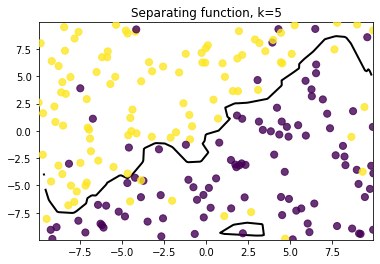

In [97]:
n = 200
D = 2

m = 0.9
q = 0.0

low_D = -10
high_D = 10

k = 1
k_new = 5

# Generate a training set WITHOUT NOISE
Xtr, Ytr = linearBinaryClass(n, D, low_D, high_D, m, q)

# flipping the labels for the training set
Ytr_flipped = flipLabels(Ytr, 10)

# Visualize the separating curve for the NN classifier with k=1
separatingFkNN(Xtr, Ytr_flipped, k)

# Generate a test set WITHOUT NOISE
Xte, Yte = linearBinaryClass(n, D, low_D, high_D, m, q)

# flipping the labels for the test set
Yte_flipped = flipLabels(Yte, 10)

# Evaluate the NN classifier on the TEST SET
Ypred = kNNClassify(Xtr, Ytr_flipped, k, Xte)

# Compute the error on the TEST SET
err = calcError(Ypred, Yte_flipped)

print("With K=%d the error on the test set is " % (k), err)

# How the classifier perform on the TRAINING SET instead?
Ypredtr = kNNClassify(Xtr, Ytr_flipped, k, Xtr) # by doing this, I'm valuating the fitting capability
errtr = calcError(Ypredtr, Ytr_flipped)
print("With K=%d the error on the training set is " % (k), errtr)

# Repeat the steps above with k=5

# Visualize the separating curve for the NN classifier with k=5
separatingFkNN(Xtr, Ytr_flipped, k_new)
Ypred_new = kNNClassify(Xtr, Ytr_flipped, k_new, Xte)
err_new = calcError(Ypred_new, Yte_flipped)
print("With K=%d the error on the test set is " % (k_new), err_new)

# How the classifier perform on the TRAINING SET instead?
Ypredtr_new = kNNClassify(Xtr, Ytr_flipped, k_new, Xtr) # by doing this, I'm valuating the fitting capability
errtr_new = calcError(Ypredtr_new, Ytr_flipped)
print("With K=%d the error on the training set is " % (k_new), errtr_new)


Describe here what changes:

*With k=5, the error on the test set is lower but the error on the training set increased. In addition to that, some noisy points in the yellow/purple region are ignored by the separation line.*

### Assignment 5

Analyse the performance of the **KNN** with plots, considering in particular the following:



- **SCENARIO 1**: Fix the number n of points to 200, fix the amount of noise to 10%, and plot the performance of the KNN classifier on TRAINING and TEST SETS as you increase the value of K

- **SCENARIO 2**: Fix the number n of points to 200, fix the value of K to a reasonable number of neighbours, and plot the performance of the KNN classifier on TRAINING and TEST SETS as you increase the amount of noise

- **SCENARIO 3**: Fix noise and K to two reasonable values, fix the number of TEST samples to 300, and plot the performance of the KNN classifier on TRAINING and TEST SETS as you increase the number of TRAINING samples (e.g. from 30 to 300 with steps 30)

- **SCENARIO 4**: Fix K and plot the performance of the KNN classifier on TRAINING and TEST SETS as you increase the amount of noise and the number of points

For each scenario, describe what happen

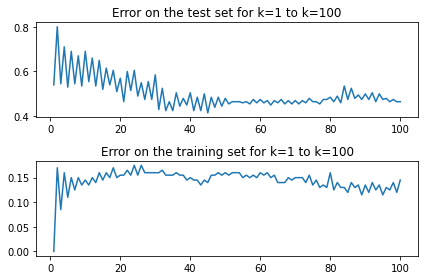

In [98]:
# SCENARIO 1
n = 200
D = 2

m = 0.9
q = 0.0

low_D = -10
high_D = 10

p_noise = 10

k = 100

# Generate a training set WITHOUT NOISE
Xtr, Ytr = linearBinaryClass(n, D, low_D, high_D, m, q)

# flipping the labels for the training set
Ytr_flipped = flipLabels(Ytr, p_noise)

# Generate a test set WITHOUT NOISE
Xte, Yte = linearBinaryClass(n, D, low_D, high_D, m, q)

# flipping the labels for the test set
Yte_flipped = flipLabels(Yte, p_noise)

# Evaluate the NN classifier on the TEST SET with increasing k
err = []
for i in range(1,k+1):  # k+1 as the range function would have stopped at k-1
  Ypred = kNNClassify(Xtr, Ytr_flipped, i, Xte)
  # Compute the error on the TEST SET
  err.append(calcError(Ypred, Yte_flipped))

# How the classifier perform on the TRAINING SET instead?
err_tr = []
for i in range(1,k+1):
  Ypred_tr = kNNClassify(Xtr, Ytr_flipped, i, Xtr)
  # Compute the error on the TRAINING SET
  err_tr.append(calcError(Ypred_tr, Ytr_flipped))

plt.figure()
plt.subplot(2,1,1)
plt.plot(range(1,k+1),err)
plt.title("Error on the test set for k=1 to k=100")
plt.subplot(2,1,2)
plt.plot(range(1,k+1),err_tr)
plt.title("Error on the training set for k=1 to k=100")
plt.tight_layout()  # no overlapping titles

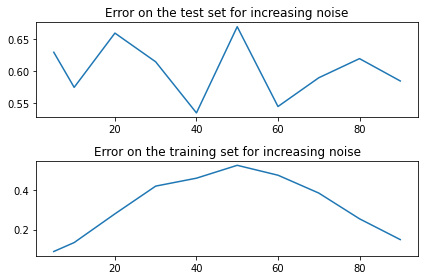

In [99]:
# SCENARIO 2
n = 200
D = 2

m = 0.9
q = 0.0

low_D = -10
high_D = 10

p_noise = [5,10,20,30,40,50,60,70,80,90]  # 100% noise is a no-sense: all the labels are flipped.

k = 10  # chosen by looking at the previous plots

# Generate a training set WITHOUT NOISE
Xtr, Ytr = linearBinaryClass(n, D, low_D, high_D, m, q)
# flipping the labels for the training set
Ytr_flipped = []
for i in p_noise:
  Ytr_flipped.append(flipLabels(Ytr, i))

# Generate a test set WITHOUT NOISE
Xte, Yte = linearBinaryClass(n, D, low_D, high_D, m, q)
# flipping the labels for the test set
Yte_flipped = []
for i in p_noise:
  Yte_flipped.append(flipLabels(Yte, i))

# Evaluate the NN classifier on the TEST SET
err = []
for i in range(len(p_noise)):
  Ypred = kNNClassify(Xtr, Ytr_flipped[i], k, Xte)  # calculate prediction with every noise value
  err.append(calcError(Ypred,Yte_flipped[i]))

# Evaluate the NN classifier on the TRAIN SET
err_tr = []
for i in range(len(p_noise)):
  Ypred_tr = kNNClassify(Xtr, Ytr_flipped[i], k, Xtr)  # calculate prediction with every noise value
  err_tr.append(calcError(Ypred_tr,Ytr_flipped[i]))

plt.figure()
plt.subplot(2,1,1)
plt.plot(p_noise,err)
plt.title("Error on the test set for increasing noise")
plt.subplot(2,1,2)
plt.plot(p_noise,err_tr)
plt.title("Error on the training set for increasing noise")
plt.tight_layout()  # no overlapping titles

[[0.21666667 0.49666667]
 [0.22666667 0.45666667]
 [0.21666667 0.48666667]
 [0.23333333 0.50666667]
 [0.18333333 0.51      ]
 [0.20666667 0.57333333]
 [0.20666667 0.53666667]
 [0.21       0.55      ]
 [0.23666667 0.45      ]]


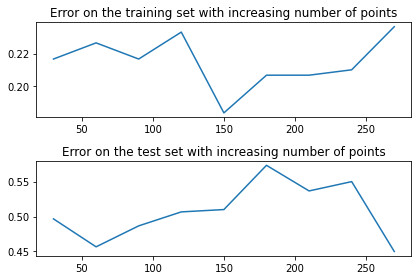

In [100]:
# SCENARIO 3
n = 300
D = 2

m = 0.9
q = 0.0

low_D = -10
high_D = 10

p_noise = 20  # chosen by looking at the previous plots

k = 15  # chosen by looking at the previous plots

# Generate a test set and add noise
Xte, Yte = linearBinaryClass(n, D, low_D, high_D, m, q)
Yte_flipped = flipLabels(Yte, p_noise)
errors=np.empty(shape=(9,2))
#print(errors) # check array creation
#print(len(errors))

for i in range(30,n,30):
  for j in range(len(errors)):
    # Generate a training set and add noise
    Xtr, Ytr = linearBinaryClass(n, D, low_D, high_D, m, q)
    Ytr_flipped = flipLabels(Ytr, p_noise)
    # Evaluate the NN classifier on the TRAINING SET and TEST SET
    Ypred_tr = kNNClassify(Xtr, Ytr_flipped, k , Xtr)
    Ypred = kNNClassify(Xtr, Ytr_flipped, k, Xte)
    # Compute the error on the TRAINING SET and TEST SET
    errors[j,0] = calcError(Ypred_tr, Ytr_flipped)
    errors[j,1] = calcError(Ypred, Yte_flipped)
print(errors) # check if the matrix is correctly filled
# plot the errors
plt.figure()
plt.subplot(2,1,1)
plt.plot(range(30,n,30),errors[:,0])
plt.title('Error on the training set with increasing number of points')
plt.subplot(2,1,2)
plt.plot(range(30,n,30),errors[:,1])
plt.title('Error on the test set with increasing number of points')
plt.tight_layout()  # no overlapping titles

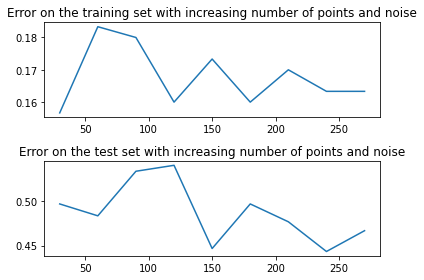

In [101]:
# SCENARIO 4
n = 300
D = 2

m = 0.9
q = 0.0

low_D = -10
high_D = 10

k = 15

errors=np.empty(shape=(9,2))

for i in range(30,n,30):
  for j in range(len(errors)):
    for ii in range(5,90,10):
      # Generate a training set and add noise
      Xtr, Ytr = linearBinaryClass(n, D, low_D, high_D, m, q)
      Ytr_flipped = flipLabels(Ytr, ii)
      Xte, Yte = linearBinaryClass(n, D, low_D, high_D, m, q)
      Yte_flipped = flipLabels(Yte, ii)
      #print(Ytr)
      # Evaluate the NN classifier on the TRAINING SET and TEST SET
      Ypred_tr = kNNClassify(Xtr, Ytr_flipped, k , Xtr)
      Ypred = kNNClassify(Xtr, Ytr_flipped, k, Xte)
      # Compute the error on the TRAINING SET and TEST SET
      errors[j,0] = calcError(Ypred_tr, Ytr_flipped)
      errors[j,1] = calcError(Ypred, Yte_flipped)

# plot the errors
plt.figure()
plt.subplot(2,1,1)
plt.plot(range(30,n,30),errors[:,0])
plt.title('Error on the training set with increasing number of points and noise')
plt.subplot(2,1,2)
plt.plot(range(30,n,30),errors[:,1])
plt.title('Error on the test set with increasing number of points and noise')
plt.tight_layout()  # no overlapping titles


Insert here your observations:
- **SCENARIO 1**: *As you increase the value of k, the error on the test set is lower while on the training set it's stable around 12%*

- **SCENARIO 2**: *As you increase the amount of noise (i.e. flipping the points from one region of the plot to another), the error on the training set is low for small noise values and for high ones (as I'm flipping almost all the points); in the test set we have high eorr values if we flip half of the points (that's reasonable as we picked a small k value)*

- **SCENARIO 3**: *As you increase the number of training samples, we have a stable 20% error on the training set, despite the number of points added; on the other hand, in the test set the error is higher (around 50%) but it decrease near n=250*

- **SCENARIO 4**: *Here the behaviour on the training set is similar to the previous scenario but the error is lower; the same happens on the test set but the line is more unstable*